# CMAPSS Engine RUL Prediction - Team POC Project

## Team Information

**Team Members**:

- **Bing GAO** - FD001 Dataset Analysis
- **Yunchong MAO** - FD002 Dataset Analysis
- **Nicolas CHANG** - FD003 Dataset Analysis

**Date**: October 24, 2025

**Phase**: Step 1 - Proof of Concept (POC)

---

## Project Overview

Predict the **Remaining Useful Life (RUL)** of aircraft engines using NASA CMAPSS dataset. Each member analyzed a different dataset with varying complexity.


## Dataset Characteristics Comparison

| Dataset | Analyst       | Training | Test | Conditions      | Failure Modes | Complexity |
| ------- | ------------- | -------- | ---- | --------------- | ------------- | ---------- |
| FD001   | Bing GAO      | 100      | 100  | ONE (Sea Level) | ONE (HPC)     | Low        |
| FD002   | Yunchong MAO  | 260      | 259  | SIX             | ONE (HPC)     | Medium     |
| FD003   | Nicolas CHANG | 100      | 100  | ONE (Sea Level) | TWO (HPC+Fan) | Medium     |

---


# Part I: FD001 Analysis (Bing GAO)

**Dataset**: Single Operating Condition, Single Failure Mode (HPC Degradation)

---


## 1. Problem Formalization

### 1.1 Problem Definition

This is a **regression task** with the objective of predicting the number of cycles an engine can still operate before failure (RUL).

### 1.2 Data Structure Description

**Training Set Characteristics**:

- Each engine starts operation from a normal state
- Gradually degrades over time
- Data is recorded until system failure
- We can calculate RUL at each time point: RUL = max_cycles - current_cycle

**Test Set Characteristics**:

- Each engine's data is truncated at some point before failure
- We need to predict the remaining cycles from the last recorded cycle to failure
- True RUL values are provided in RUL_FD001.txt for evaluation

### 1.3 Data Format

Each row contains 26 columns:

1. unit_id: Engine identifier
2. time_cycles: Number of operational cycles
   3-5. operational_setting_1/2/3: Three operational setting parameters
   6-26. sensor_1 to sensor_21: 21 sensor measurements

### 1.4 FD001 Characteristics

- **Single operating condition**: All engines operate under the same conditions (Sea Level)
- **Single failure mode**: Only HPC degradation
- Relatively simplified scenario, suitable for rapid POC validation

### 1.5 Evaluation Metric

Using **RMSE (Root Mean Square Error)** as the primary evaluation metric:
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$


## 2. Data Loading and Initial Exploration


In [141]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [142]:
# Define column names
# 26 columns: unit_id, time_cycles, 3 operational settings, 21 sensors
column_names = ['unit_id', 'time_cycles'] + \
               [f'setting_{i}' for i in range(1, 4)] + \
               [f'sensor_{i}' for i in range(1, 22)]

# Data file path
data_path = '../CMAPSSData/'

# Load training set
train_df = pd.read_csv(data_path + 'train_FD001.txt', sep='\s+', header=None, names=column_names)

# Load test set
test_df = pd.read_csv(data_path + 'test_FD001.txt', sep='\s+', header=None, names=column_names)

# Load true RUL values
rul_df = pd.read_csv(data_path + 'RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"RUL labels shape: {rul_df.shape}")
print("\nData loaded successfully!")


Training set shape: (20631, 26)
Test set shape: (13096, 26)
RUL labels shape: (100, 1)

Data loaded successfully!


In [143]:
# View first few rows of training set
print("First 5 rows of training set:")
train_df.head()


First 5 rows of training set:


,unit_id,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [144]:
# Basic data information
print("Training set data info:")
print(train_df.info())
print("\n" + "="*50 + "\n")

# Check for missing values
print("Training set missing values:")
print(train_df.isnull().sum().sum())
print("\nTest set missing values:")
print(test_df.isnull().sum().sum())


Training set data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_id      20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   sensor_1     20631 non-null  float64
 6   sensor_2     20631 non-null  float64
 7   sensor_3     20631 non-null  float64
 8   sensor_4     20631 non-null  float64
 9   sensor_5     20631 non-null  float64
 10  sensor_6     20631 non-null  float64
 11  sensor_7     20631 non-null  float64
 12  sensor_8     20631 non-null  float64
 13  sensor_9     20631 non-null  float64
 14  sensor_10    20631 non-null  float64
 15  sensor_11    20631 non-null  float64
 16  sensor_12    20631 non-null  float64
 17  sensor_13    20631 non-null  float64
 18  sensor_14    20631 non

In [145]:
# Calculate RUL (Remaining Useful Life) for training set
# RUL = max cycles for each engine - current cycle

# Calculate maximum cycles for each engine
max_cycles = train_df.groupby('unit_id')['time_cycles'].max().reset_index()
max_cycles.columns = ['unit_id', 'max_cycle']

# Merge back to training set
train_df = train_df.merge(max_cycles, on='unit_id', how='left')

# Calculate RUL
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# Drop auxiliary column
train_df = train_df.drop('max_cycle', axis=1)

print("Training set RUL calculation completed!")
print(f"\nRUL statistics:")
print(train_df['RUL'].describe())


Training set RUL calculation completed!

RUL statistics:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64


## 3. Exploratory Data Analysis (EDA)

### 3.1 Engine Lifecycle Analysis


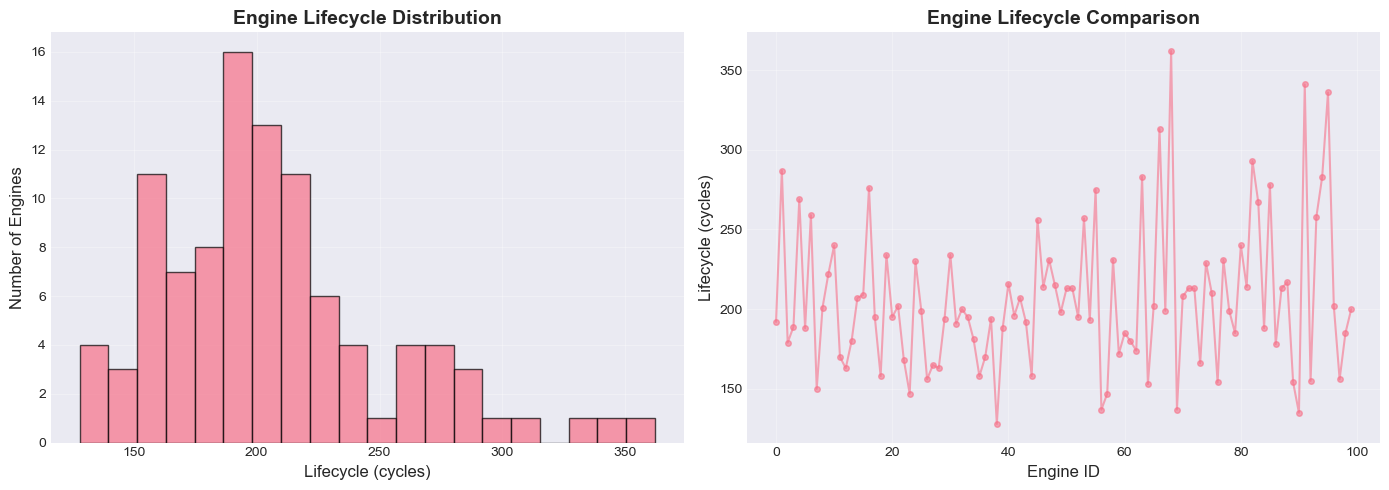

Lifecycle statistics:
  Min: 128 cycles
  Max: 362 cycles
  Mean: 206.31 cycles
  Median: 199.00 cycles


In [146]:
# View lifecycle length for each engine
engine_life = train_df.groupby('unit_id')['time_cycles'].max()

plt.figure(figsize=(14, 5))

# Subplot 1: Lifecycle distribution
plt.subplot(1, 2, 1)
plt.hist(engine_life, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Lifecycle (cycles)', fontsize=12)
plt.ylabel('Number of Engines', fontsize=12)
plt.title('Engine Lifecycle Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 2: Lifecycle for each engine
plt.subplot(1, 2, 2)
plt.plot(engine_life.values, marker='o', linestyle='-', markersize=4, alpha=0.6)
plt.xlabel('Engine ID', fontsize=12)
plt.ylabel('Lifecycle (cycles)', fontsize=12)
plt.title('Engine Lifecycle Comparison', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Lifecycle statistics:")
print(f"  Min: {engine_life.min()} cycles")
print(f"  Max: {engine_life.max()} cycles")
print(f"  Mean: {engine_life.mean():.2f} cycles")
print(f"  Median: {engine_life.median():.2f} cycles")


### 3.2 Operational Settings Analysis

**Note**: FD001 is a single operating condition dataset, the 3 operational settings are expected to be constant or vary very little


In [147]:
# Check operational settings statistics
setting_cols = ['setting_1', 'setting_2', 'setting_3']

print("Operational settings statistics:\n")
for col in setting_cols:
    unique_vals = train_df[col].nunique()
    std_val = train_df[col].std()
    print(f"{col}:")
    print(f"  Unique values: {unique_vals}")
    print(f"  Standard deviation: {std_val:.6f}")
    print(f"  Range: [{train_df[col].min():.6f}, {train_df[col].max():.6f}]")
    print()

print("\nConclusion: Since FD001 is a single operating condition, these setting columns vary minimally and can be considered for removal")


Operational settings statistics:

setting_1:
  Unique values: 158
  Standard deviation: 0.002187
  Range: [-0.008700, 0.008700]

setting_2:
  Unique values: 13
  Standard deviation: 0.000293
  Range: [-0.000600, 0.000600]

setting_3:
  Unique values: 1
  Standard deviation: 0.000000
  Range: [100.000000, 100.000000]


Conclusion: Since FD001 is a single operating condition, these setting columns vary minimally and can be considered for removal


### 3.3 Sensor Data Analysis

**Objectives**:

- Identify constant sensors (variance is 0 or extremely small)
- View sensor degradation trends over time
- Analyze sensor correlation with RUL


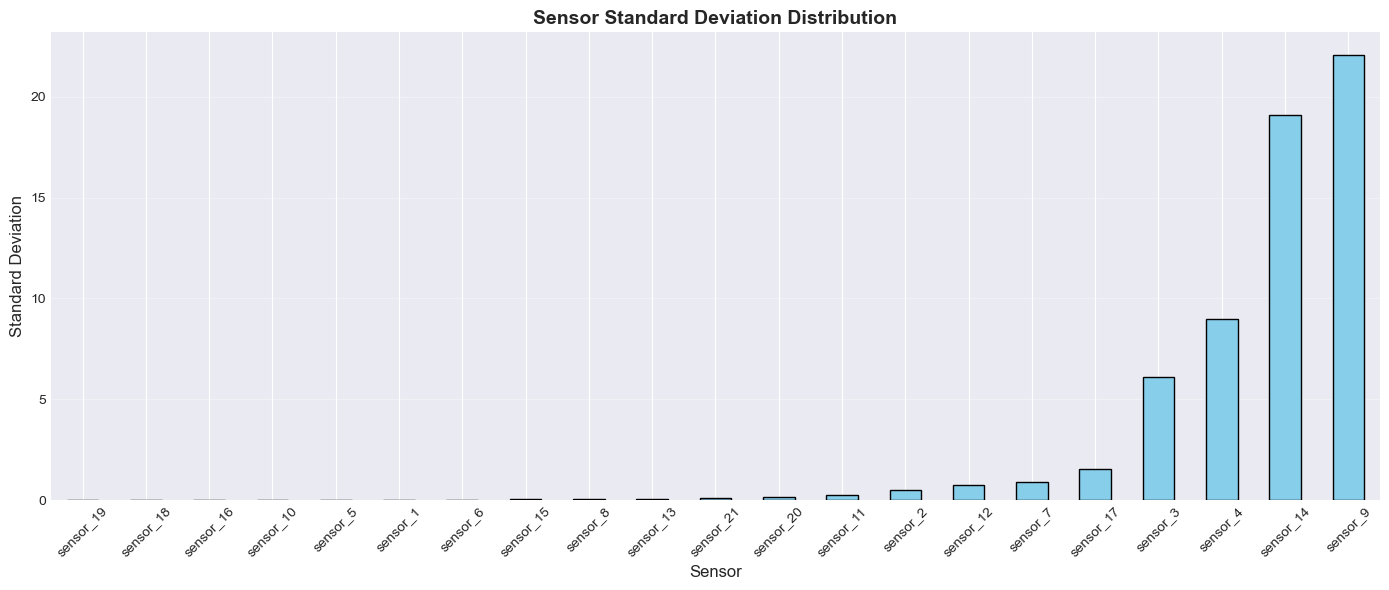


Sensors with extremely small variance (std < 0.01): ['sensor_19', 'sensor_18', 'sensor_16', 'sensor_10', 'sensor_5', 'sensor_1', 'sensor_6']
Count: 7

These sensors have minimal variation and contain little useful information, they can be removed


In [148]:
# Identify constant sensors (columns with extremely small variance)
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]

# Calculate standard deviation for each sensor
sensor_std = train_df[sensor_cols].std().sort_values()

# Visualization
plt.figure(figsize=(14, 6))
sensor_std.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Sensor', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
plt.title('Sensor Standard Deviation Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Identify sensors with extremely small variance (std < 0.01)
constant_sensors = sensor_std[sensor_std < 0.01].index.tolist()
print(f"\nSensors with extremely small variance (std < 0.01): {constant_sensors}")
print(f"Count: {len(constant_sensors)}")

print(f"\nThese sensors have minimal variation and contain little useful information, they can be removed")


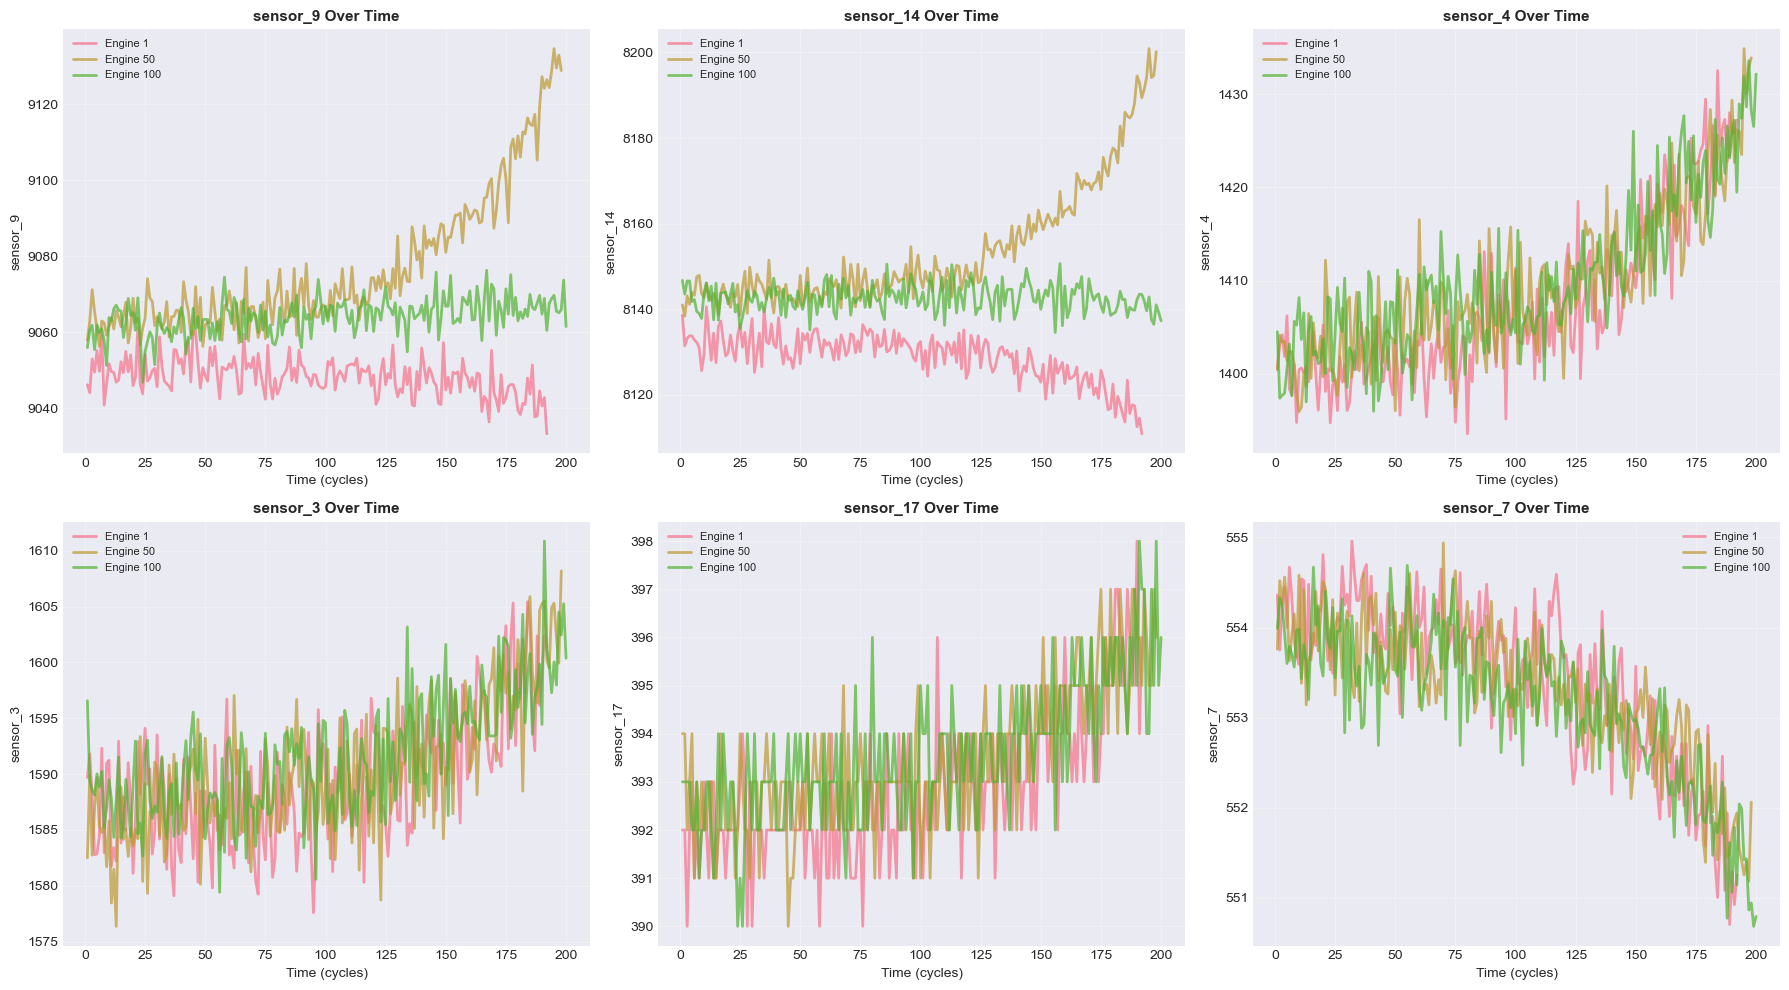

Visualized degradation trends for the 6 sensors with largest standard deviation
Observation: Some sensors show clear degradation patterns, which are valuable for RUL prediction


In [149]:
# Visualize sensor degradation trends for representative engines
# Select sensors with larger standard deviation (more likely to contain degradation information)
top_sensors = sensor_std.nlargest(6).index.tolist()

# Select 3 representative engines
selected_engines = [1, 50, 100]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, sensor in enumerate(top_sensors):
    ax = axes[idx]
    for engine_id in selected_engines:
        engine_data = train_df[train_df['unit_id'] == engine_id]
        ax.plot(engine_data['time_cycles'], engine_data[sensor], 
                label=f'Engine {engine_id}', alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Time (cycles)', fontsize=10)
    ax.set_ylabel(sensor, fontsize=10)
    ax.set_title(f'{sensor} Over Time', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Visualized degradation trends for the 6 sensors with largest standard deviation")
print(f"Observation: Some sensors show clear degradation patterns, which are valuable for RUL prediction")


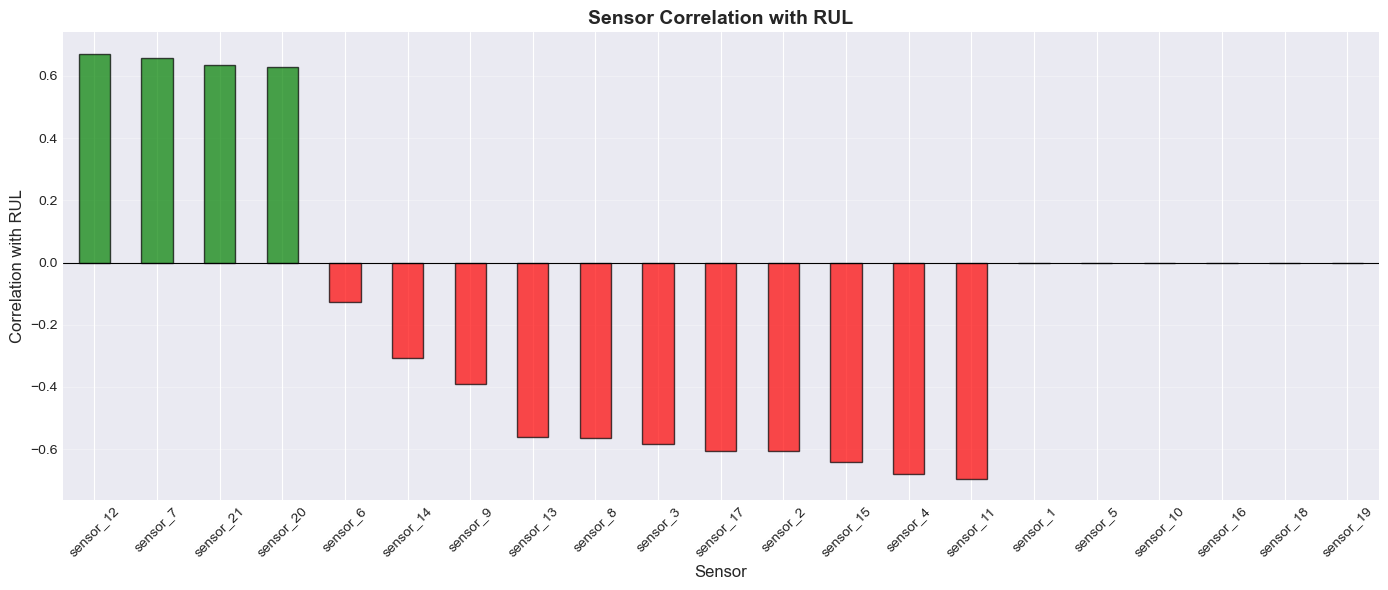


Sensors with strongest correlation to RUL (absolute value):
sensor_11    0.696228
sensor_4     0.678948
sensor_12    0.671983
sensor_7     0.657223
sensor_15    0.642667
sensor_21    0.635662
sensor_20    0.629428
sensor_2     0.606484
sensor_17    0.606154
sensor_3     0.584520
Name: RUL, dtype: float64

Analysis: Some sensors have strong correlation with RUL (positive or negative), these are key features


In [150]:
# Analyze sensor correlation with RUL
correlation_with_rul = train_df[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

plt.figure(figsize=(14, 6))
correlation_with_rul.plot(kind='bar', color=['green' if x > 0 else 'red' for x in correlation_with_rul], 
                          edgecolor='black', alpha=0.7)
plt.xlabel('Sensor', fontsize=12)
plt.ylabel('Correlation with RUL', fontsize=12)
plt.title('Sensor Correlation with RUL', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nSensors with strongest correlation to RUL (absolute value):")
print(correlation_with_rul.abs().sort_values(ascending=False).head(10))

print("\nAnalysis: Some sensors have strong correlation with RUL (positive or negative), these are key features")


## 4. Preprocessing Implementation

### 4.1 Feature Selection

**Strategy**:

- Remove operational setting columns (FD001 single condition, minimal variation)
- Remove constant sensors (sensors with extremely small variance)
- Keep useful sensor data


In [151]:
# Define columns to drop
cols_to_drop = setting_cols + constant_sensors

print(f"Columns to be dropped: {cols_to_drop}")
print(f"Number of columns to drop: {len(cols_to_drop)}")

# Create copies of training and test data
train_processed = train_df.copy()
test_processed = test_df.copy()

# Drop unnecessary columns
train_processed = train_processed.drop(cols_to_drop, axis=1)
test_processed = test_processed.drop(cols_to_drop, axis=1)

print(f"\nProcessed training set shape: {train_processed.shape}")
print(f"Processed test set shape: {test_processed.shape}")

# Display retained columns
feature_cols = [col for col in train_processed.columns if col not in ['unit_id', 'time_cycles', 'RUL']]
print(f"\nNumber of retained feature columns: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


Columns to be dropped: ['setting_1', 'setting_2', 'setting_3', 'sensor_19', 'sensor_18', 'sensor_16', 'sensor_10', 'sensor_5', 'sensor_1', 'sensor_6']
Number of columns to drop: 10

Processed training set shape: (20631, 17)
Processed test set shape: (13096, 16)

Number of retained feature columns: 14
Feature columns: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']


### 4.2 Data Normalization

**Reason**:

- Different sensors have vastly different scales and ranges
- Normalization can improve model performance and training speed
- Using MinMaxScaler to scale data to [0, 1] range


In [152]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler on training set
scaler.fit(train_processed[feature_cols])

# Normalize training and test sets
train_processed[feature_cols] = scaler.transform(train_processed[feature_cols])
test_processed[feature_cols] = scaler.transform(test_processed[feature_cols])

print("Data normalization completed!")
print(f"\nNormalized data range example (first 5 features):")
print(train_processed[feature_cols[:5]].describe())


Data normalization completed!

Normalized data range example (first 5 features):
           sensor_2      sensor_3      sensor_4      sensor_7      sensor_8
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.000000
mean       0.443052      0.424746      0.450435      0.566459      0.297957
std        0.150618      0.133664      0.151935      0.142527      0.107554
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.335843      0.331807      0.339467      0.476651      0.227273
50%        0.430723      0.415522      0.435348      0.578100      0.287879
75%        0.539157      0.508829      0.545324      0.669887      0.363636
max        1.000000      1.000000      1.000000      1.000000      1.000000


### 4.3 Preparing Training and Test Data

**Training Strategy Improvement**:

- **Use all time points** (instead of only the last point)
- Reasons:
  - Using only the last point results in too few training samples (only 100)
  - Lack of data diversity prevents the model from learning degradation patterns
  - All time points provide complete degradation trajectory information
- This provides approximately 20,000 training samples, significantly improving model performance

**Test Strategy**:

- For the test set, use the last time point of each engine
- Predict the corresponding RUL value (this is the real application scenario)

**Room for Improvement**:

- Future work can use sliding window methods
- Consider RUL truncation (e.g., upper limit of 125 cycles)
- Add temporal features (trends, rate of change, etc.)


In [ ]:
print("="*60)
print("Preparing Training and Test Data")
print("="*60)

# For training set: use all time points
X_train_full = train_processed[feature_cols]
y_train_full = train_processed['RUL']

print(f"\nTraining data statistics:")
print(f"  Total samples: {len(X_train_full)}")
print(f"  Number of engines: {train_processed['unit_id'].nunique()}")
print(f"  Number of features: {len(feature_cols)}")
print(f"  RUL range: [{y_train_full.min()}, {y_train_full.max()}]")

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"\nData split:")
print(f"  Training set size: {X_train.shape}")
print(f"  Validation set size: {X_val.shape}")

# For test set: take the last time point of each engine
test_last = test_processed.groupby('unit_id').last().reset_index()
X_test = test_last[feature_cols]
y_test = rul_df['RUL'].values

print(f"\nTest set:")
print(f"  Test set size: {X_test.shape}")
print(f"  Test labels size: {y_test.shape}")
print(f"  RUL range: [{y_test.min()}, {y_test.max()}]")

print("\n✓ Data preparation completed!")
print("="*60)


Preparing Training and Test Data

Training data statistics:
  Total samples: 20631
  Number of engines: 100
  Number of features: 14
  RUL range: [0, 361]

Data split:
  Training set size: (16504, 14)
  Validation set size: (4127, 14)

Test set:
  Test set size: (100, 14)
  Test labels size: (100,)
  RUL range: [7, 145]

✓ Data preparation completed!


## 5. Model Training and Evaluation

### 5.1 Model Selection

**POC Phase Selection**:

- **Random Forest**: As a baseline model, stable and easy to interpret
- **XGBoost**: Usually performs excellently on structured data

**Why choose these models**:

- No complex feature engineering required
- Fast training speed, suitable for POC
- Good ability to fit non-linear relationships
- Future work can try LSTM and other deep learning models to leverage temporal information


### 5.2 Random Forest Model


In [154]:
# Train Random Forest model
print("="*60)
print("Training Random Forest Model...")
print("="*60)

# Check data preparation
print(f"\nData check:")
print(f"  Training features shape: {X_train.shape}")
print(f"  Training labels shape: {y_train.shape}")
print(f"  Validation features shape: {X_val.shape}")
print(f"  Test features shape: {X_test.shape}")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print(f"\nStarting training...")
rf_model.fit(X_train, y_train)
print("✓ Model training completed!")

# Predict on validation set
print("\nMaking predictions...")
y_val_pred_rf = rf_model.predict(X_val)

# Predict on test set
y_test_pred_rf = rf_model.predict(X_test)
print("✓ Predictions completed!")

# Calculate evaluation metrics
val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)

test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\n" + "="*60)
print("=== Random Forest Results ===")
print("="*60)
print(f"\n【Validation Performance】")
print(f"  RMSE: {val_rmse_rf:.2f} cycles")
print(f"  MAE:  {val_mae_rf:.2f} cycles")
print(f"  R²:   {val_r2_rf:.4f}")
print(f"\n【Test Performance】")
print(f"  RMSE: {test_rmse_rf:.2f} cycles")
print(f"  MAE:  {test_mae_rf:.2f} cycles")
print(f"  R²:   {test_r2_rf:.4f}")
print("\n" + "="*60)


Training Random Forest Model...

Data check:
  Training features shape: (16504, 14)
  Training labels shape: (16504,)
  Validation features shape: (4127, 14)
  Test features shape: (100, 14)

Starting training...
✓ Model training completed!

Making predictions...
✓ Predictions completed!

=== Random Forest Results ===

【Validation Performance】
  RMSE: 41.31 cycles
  MAE:  29.48 cycles
  R²:   0.6265

【Test Performance】
  RMSE: 33.12 cycles
  MAE:  24.24 cycles
  R²:   0.3646




Feature Importance Analysis


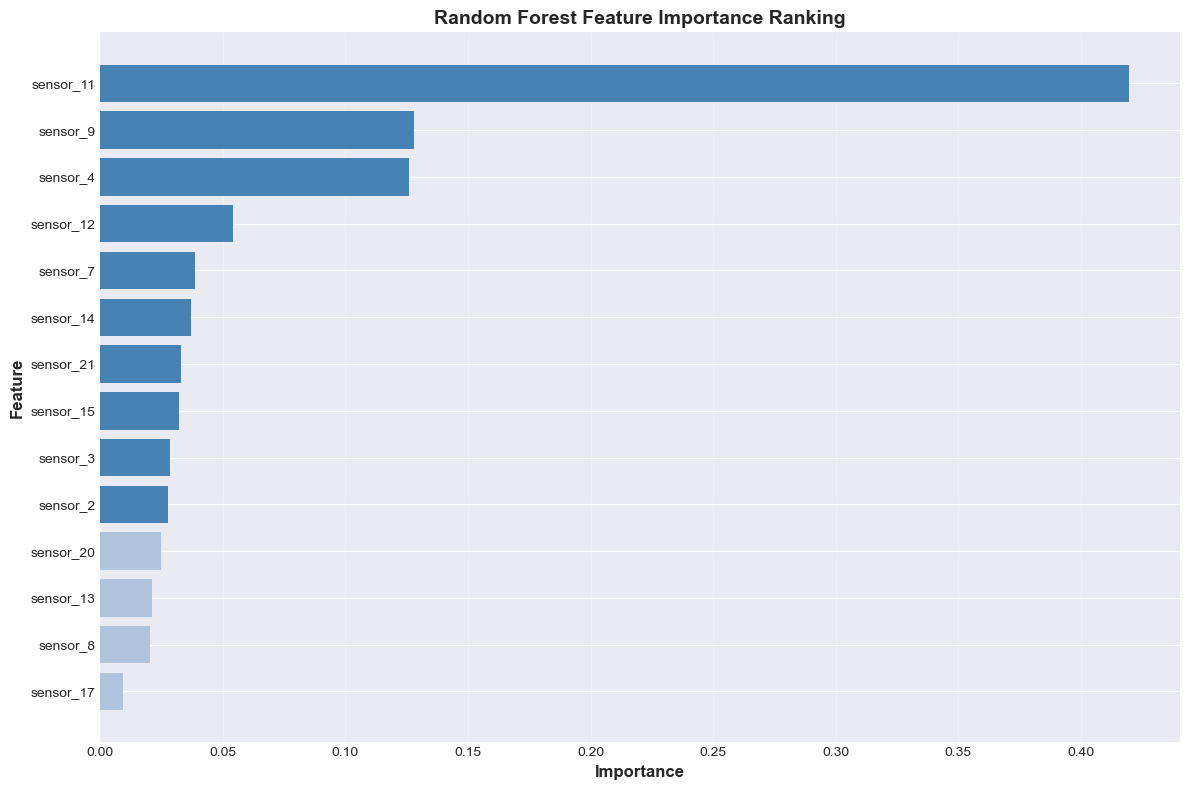


✓ Top 10 Most Important Features:
----------------------------------------
  sensor_11    : 0.4195
  sensor_9     : 0.1280
  sensor_4     : 0.1260
  sensor_12    : 0.0542
  sensor_7     : 0.0385
  sensor_14    : 0.0371
  sensor_21    : 0.0329
  sensor_15    : 0.0321
  sensor_3     : 0.0285
  sensor_2     : 0.0277

Analysis:
  - Dark blue bars represent the Top 10 most important features
  - These sensors contribute most to RUL prediction
  - Future work can focus on analyzing degradation patterns of these sensors


In [155]:
# Feature importance analysis
print("\n" + "="*60)
print("Feature Importance Analysis")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
colors = ['steelblue' if i < 10 else 'lightsteelblue' for i in range(len(feature_importance))]
plt.barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
plt.yticks(range(len(feature_importance)), feature_importance['feature'], fontsize=10)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Random Forest Feature Importance Ranking', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Display Top 10 most important features
print("\n✓ Top 10 Most Important Features:")
print("-" * 40)
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']:12s} : {row['importance']:.4f}")

print("\nAnalysis:")
print("  - Dark blue bars represent the Top 10 most important features")
print("  - These sensors contribute most to RUL prediction")
print("  - Future work can focus on analyzing degradation patterns of these sensors")


### 5.3 XGBoost Model

XGBoost is a high-performance gradient boosting model that typically performs excellently on structured data.


In [156]:
# Try importing XGBoost
try:
    import xgboost as xgb
    xgboost_available = True
    print("XGBoost available")
except ImportError:
    xgboost_available = False
    print("XGBoost not installed, will skip XGBoost model")
    print("Can install using: pip install xgboost")


XGBoost not installed, will skip XGBoost model
Can install using: pip install xgboost


In [157]:
if xgboost_available:
    # Train XGBoost model
    print("\nTraining XGBoost Model...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_val_pred_xgb = xgb_model.predict(X_val)
    
    # Predict on test set
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # Calculate evaluation metrics
    val_rmse_xgb = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
    val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
    val_r2_xgb = r2_score(y_val, y_val_pred_xgb)
    
    test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
    test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
    test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
    
    print("\n=== XGBoost Results ===")
    print(f"Validation RMSE: {val_rmse_xgb:.2f}")
    print(f"Validation MAE: {val_mae_xgb:.2f}")
    print(f"Validation R²: {val_r2_xgb:.4f}")
    print(f"\nTest RMSE: {test_rmse_xgb:.2f}")
    print(f"Test MAE: {test_mae_xgb:.2f}")
    print(f"Test R²: {test_r2_xgb:.4f}")
else:
    print("\nSkipping XGBoost model training")



Skipping XGBoost model training


### 5.4 Prediction Results Visualization


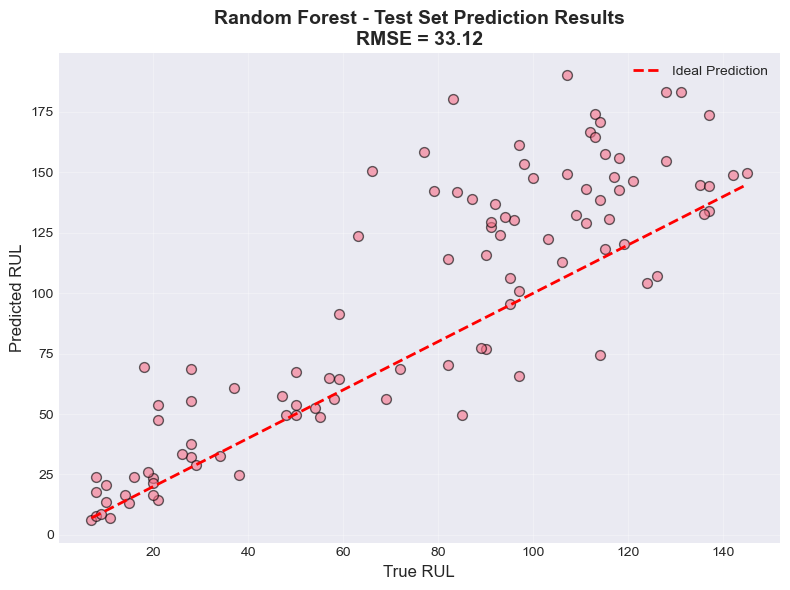

In [158]:
# Visualize test set prediction results
if xgboost_available:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Random Forest
    axes[0].scatter(y_test, y_test_pred_rf, alpha=0.6, s=50, edgecolor='black')
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', lw=2, label='Ideal Prediction')
    axes[0].set_xlabel('True RUL', fontsize=12)
    axes[0].set_ylabel('Predicted RUL', fontsize=12)
    axes[0].set_title(f'Random Forest\nRMSE = {test_rmse_rf:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # XGBoost
    axes[1].scatter(y_test, y_test_pred_xgb, alpha=0.6, s=50, color='green', edgecolor='black')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', lw=2, label='Ideal Prediction')
    axes[1].set_xlabel('True RUL', fontsize=12)
    axes[1].set_ylabel('Predicted RUL', fontsize=12)
    axes[1].set_title(f'XGBoost\nRMSE = {test_rmse_xgb:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    # Random Forest only
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred_rf, alpha=0.6, s=50, edgecolor='black')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Ideal Prediction')
    plt.xlabel('True RUL', fontsize=12)
    plt.ylabel('Predicted RUL', fontsize=12)
    plt.title(f'Random Forest - Test Set Prediction Results\nRMSE = {test_rmse_rf:.2f}', 
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


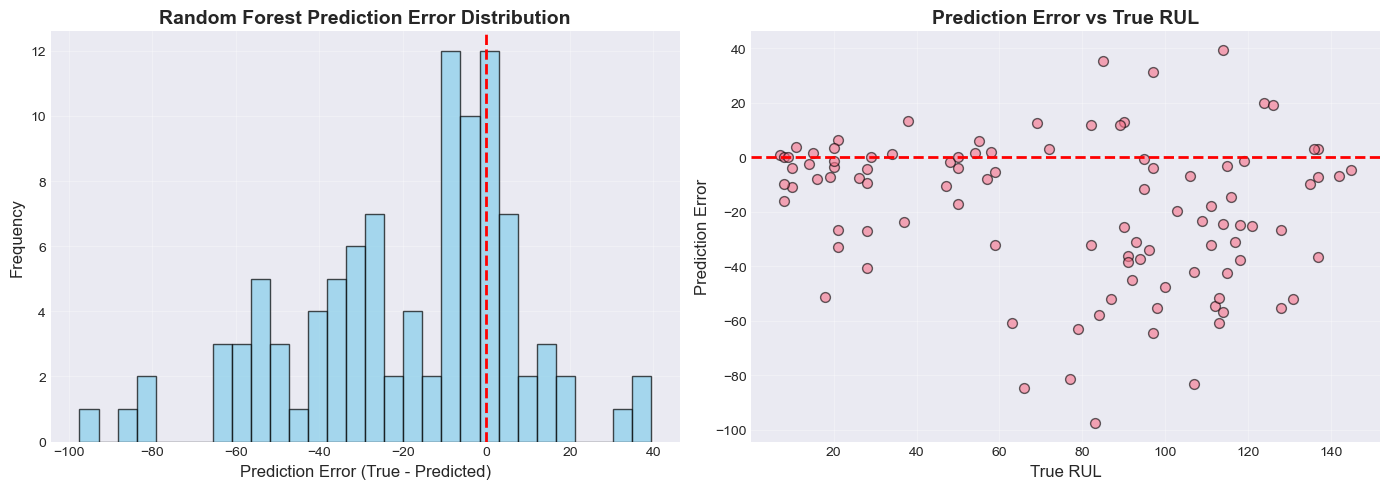


Error Statistics:
  Mean error: -19.34
  Error std dev: 26.90
  Max positive error (overestimate): 39.41
  Max negative error (underestimate): -97.44


In [159]:
# Error analysis
errors_rf = y_test - y_test_pred_rf

plt.figure(figsize=(14, 5))

# Subplot 1: Error distribution
plt.subplot(1, 2, 1)
plt.hist(errors_rf, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Prediction Error (True - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Random Forest Prediction Error Distribution', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# Subplot 2: Error vs True RUL
plt.subplot(1, 2, 2)
plt.scatter(y_test, errors_rf, alpha=0.6, s=50, edgecolor='black')
plt.xlabel('True RUL', fontsize=12)
plt.ylabel('Prediction Error', fontsize=12)
plt.title('Prediction Error vs True RUL', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nError Statistics:")
print(f"  Mean error: {errors_rf.mean():.2f}")
print(f"  Error std dev: {errors_rf.std():.2f}")
print(f"  Max positive error (overestimate): {errors_rf.max():.2f}")
print(f"  Max negative error (underestimate): {errors_rf.min():.2f}")


## 6. Results Summary and Future Directions

### 6.1 POC Summary


In [160]:
# Model performance comparison summary
print("="*60)
print("POC Phase Completed - Model Performance Summary")
print("="*60)

print("\n【Random Forest】")
print(f"  Test RMSE: {test_rmse_rf:.2f} cycles")
print(f"  Test MAE:  {test_mae_rf:.2f} cycles")
print(f"  Test R²:   {test_r2_rf:.4f}")

if xgboost_available:
    print("\n【XGBoost】")
    print(f"  Test RMSE: {test_rmse_xgb:.2f} cycles")
    print(f"  Test MAE:  {test_mae_xgb:.2f} cycles")
    print(f"  Test R²:   {test_r2_xgb:.4f}")
    
    if test_rmse_xgb < test_rmse_rf:
        print(f"\n✓ XGBoost performs better, RMSE reduced by {test_rmse_rf - test_rmse_xgb:.2f} cycles")
    else:
        print(f"\n✓ Random Forest performs better, RMSE reduced by {test_rmse_xgb - test_rmse_rf:.2f} cycles")

print("\n" + "="*60)


POC Phase Completed - Model Performance Summary

【Random Forest】
  Test RMSE: 33.12 cycles
  Test MAE:  24.24 cycles
  Test R²:   0.3646



### 6.2 Advantages and Limitations of Current Approach

**Advantages**:

- Quickly established baseline model, validated feasibility
- Random Forest model is stable and easy to interpret
- Successfully identified and removed useless constant columns
- Understood key sensors through feature importance analysis

**Limitations**:

- Feature engineering is relatively simple, did not extract rolling statistics, trends, and other advanced features
- No hyperparameter optimization performed
- Can further leverage time series models to capture degradation patterns


### 6.3 Future Improvement Directions (Step 2 Work)

**Feature Engineering Enhancement**:

- Sliding window statistical features: calculate mean, std, max, min
- Sensor combination features: create ratios, differences, and other interaction features
- Degradation indicators: calculate degradation relative to initial state

**Model Improvement**:

- Time series models: LSTM/GRU to capture long-term dependencies, 1D-CNN to extract local patterns
- Implement sliding window method to increase training samples
- Consider RUL truncation (upper limit 125 cycles)
- Hyperparameter tuning: grid search or Bayesian optimization
- Ensemble methods: combine multiple model predictions

**In-depth Analysis**:

- Sensor correlation analysis, identify redundant sensors
- Anomaly detection and data cleaning
- Segmented modeling for different degradation stages

**Evaluation Improvement**:

- Use NASA scoring function (higher penalty for underestimating RUL)
- Performance analysis across different RUL ranges


### 6.4 Conclusion

This POC successfully accomplished:

- Validated the feasibility of RUL prediction on FD001 dataset
- Established Random Forest baseline model
- Identified key sensor features
- Defined clear directions for future improvements

**Next Steps**:

- Implement more complex feature engineering (sliding windows, trend features)
- Try time series deep learning models (LSTM)
- Optimize model hyperparameters

---

**Submission Information**:

- Dataset: FD001
- Completion Date: October 24, 2025
- Phase: Step 1 - POC
- Next Phase: Step 2 In-depth Optimization


---

# Part II: FD002 Analysis (Yunchong MAO)

**Dataset**: Six Operating Conditions, Single Failure Mode (HPC Degradation)

---


In [1]:
!pip install numpy pandas scikit-learn tensorflow matplotlib

In [8]:
# decision why: we store CMAPSS files on Google Drive so every team member can access the same data version.

from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
DATA_DIR = Path("/content/drive/MyDrive/FD002")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# decision why: Check dataset folder and list files,verifying the folder structure ensures all required CMAPSS files (train, test, RUL) are present before loading.

from pathlib import Path
DATA_DIR = Path("/content/drive/MyDrive/FD002")
FD = "FD002"

!ls -lh /content/drive/MyDrive/FD002

total 15M
-rw------- 1 root root 1.1K Oct  1  2008 RUL_FD002.txt
-rw------- 1 root root 5.5M Sep 17  2008 test_FD002.txt
-rw------- 1 root root 8.7M Sep 17  2008 train_FD002.txt


In [10]:
# decision why: load data and naming, adding explicit column names (unit, cycle, ops, sensors) improves readability and avoids confusion during analysis.

import pandas as pd

col_names = ["unit", "cycle", "op1", "op2", "op3"] + [f"s{i}" for i in range(1,22)]
train = pd.read_csv(DATA_DIR / f"train_{FD}.txt", sep=r"\s+", header=None, names=col_names)
test  = pd.read_csv(DATA_DIR / f"test_{FD}.txt",  sep=r"\s+", header=None, names=col_names)
rul   = pd.read_csv(DATA_DIR / f"RUL_{FD}.txt",   sep=r"\s+", header=None, names=["RUL"])

train.head()

,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [11]:
# decision why: We compute RUL for the training set.Calculating RUL gives each engine's remaining cycles until failure, and capping at 125 stabilizes model training.

import numpy as np

RUL_CAP = 125
USE_RUL_CAP = True

def add_train_rul(df, cap=None):
    df = df.copy()
    max_cycle = df.groupby("unit")["cycle"].max().rename("max_cycle")
    df = df.merge(max_cycle, on="unit", how="left")
    df["RUL"] = df["max_cycle"] - df["cycle"]
    if cap is not None:
        df["RUL"] = np.minimum(df["RUL"], cap)
    return df.drop(columns=["max_cycle"])

train_lbl = add_train_rul(train, cap=RUL_CAP if USE_RUL_CAP else None)

display(train_lbl.head())
print("train_lbl shape:", train_lbl.shape)
print("RUL min/max:", train_lbl["RUL"].min(), train_lbl["RUL"].max())

,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,125
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,125
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,125
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,125
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,125


train_lbl shape: (53759, 27)
RUL min/max: 0 125


In [17]:

# decision why: We build test set labels with RUL_FD002.txt, test data stops before failure, so we extend each engine's last known RUL from RUL_FD002 to compute full labels.

import numpy as np
import pandas as pd

if "RUL_CAP" not in globals():
    RUL_CAP = 125
if "USE_RUL_CAP" not in globals():
    USE_RUL_CAP = True

test_last = (
    test.groupby("unit")["cycle"]
        .max()
        .reset_index()
        .rename(columns={"cycle": "max_cycle"})
)

test_m = (
    test.merge(test_last, on="unit", how="left")
        .sort_values(["unit", "cycle"])
        .reset_index(drop=True)
)

n_units = test_m["unit"].nunique()
assert len(rul) == n_units, f"Mismatch: RUL rows={len(rul)} vs test units={n_units}"

unit_order = test_m["unit"].unique()
final_rul_map = dict(zip(unit_order, rul["RUL"].values))
test_m["final_RUL"] = test_m["unit"].map(final_rul_map)

test_m["RUL"] = (test_m["final_RUL"] + (test_m["max_cycle"] - test_m["cycle"])).astype(int)

if USE_RUL_CAP:
    test_m["RUL"] = np.minimum(test_m["RUL"], RUL_CAP)

test_lbl = test_m.drop(columns=["final_RUL"])

display(test_lbl.head(8))
print("test_lbl shape:", test_lbl.shape)
print("RUL range: ", int(test_lbl["RUL"].min()), "to", int(test_lbl["RUL"].max()))
print("Units (test):", test_lbl["unit"].nunique(), " | RUL rows:", len(rul))

,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,max_cycle,RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,258,125
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,258,125
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,258,125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,258,125
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,258,125
5,1,6,25.0006,0.6206,60.0,462.54,536.62,1258.90,1047.35,7.05,...,7859.98,10.9378,0.02,307,1915,84.93,14.26,8.4941,258,125
6,1,7,42.0017,0.8400,100.0,445.00,549.47,1351.28,1124.43,3.91,...,8069.15,9.3595,0.02,330,2212,100.00,10.57,6.3555,258,125
7,1,8,41.9994,0.8404,100.0,445.00,549.49,1349.20,1126.95,3.91,...,8068.88,9.3753,0.02,330,2212,100.00,10.67,6.2992,258,125


test_lbl shape: (33991, 28)
RUL range:  6 to 125
Units (test): 259  | RUL rows: 259


In [19]:
# decision why: select failure and remove near-constant sensors to reduce noise, and add first-order differences (_d1) to capture degradation trends over time.

sensor_cols = [c for c in test_lbl.columns if c.startswith("s")]
keep_sensors = [c for c in sensor_cols if train_lbl[c].std() > 1e-3]

feature_cols = ["op1","op2","op3"] + keep_sensors

def add_deltas(df, cols):
    df = df.sort_values(["unit","cycle"]).copy()
    for c in cols:
        df[c+"_d1"] = df.groupby("unit")[c].diff().fillna(0.0)
    return df

train_feat = add_deltas(train_lbl, keep_sensors)
test_feat  = add_deltas(test_lbl,  keep_sensors)

feature_cols = feature_cols + [c+"_d1" for c in keep_sensors]

print("Sensors kept:", len(keep_sensors))
print("Total features:", len(feature_cols))

Sensors kept: 21
Total features: 45


In [25]:
# decision why: cluster.FD002 has multiple operating conditions; clustering by op1–op3 and scaling within each cluster avoids mixing different regimes.

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

SEED = 42
np.random.seed(SEED)

K = 4
kmeans = KMeans(n_clusters=K, random_state=SEED, n_init="auto")
train_feat["cluster"] = kmeans.fit_predict(train_feat[["op1","op2","op3"]])
test_feat["cluster"]  = kmeans.predict(test_feat[["op1","op2","op3"]])

scalers = {}
for k in range(K):
    scaler = StandardScaler()
    idx = (train_feat["cluster"] == k)
    scaler.fit(train_feat.loc[idx, feature_cols])
    scalers[k] = scaler

def scale_by_cluster(df, feature_cols, scalers):
    X = np.zeros((len(df), len(feature_cols)), dtype=np.float32)
    for k, scaler in scalers.items():
        idx = (df["cluster"] == k)
        X[idx] = scaler.transform(df.loc[idx, feature_cols])
    return X

X_train_all = scale_by_cluster(train_feat, feature_cols, scalers)
y_train_all = train_feat["RUL"].values.astype(np.float32)

X_test_all  = scale_by_cluster(test_feat, feature_cols, scalers)
y_test_all  = test_feat["RUL"].values.astype(np.float32)

print("X_train_all:", X_train_all.shape, "| X_test_all:", X_test_all.shape)
print("y ranges — train:", (y_train_all.min(), y_train_all.max()),
      " test:", (y_test_all.min(), y_test_all.max()))

X_train_all: (53759, 45) | X_test_all: (33991, 45)
y ranges — train: (np.float32(0.0), np.float32(125.0))  test: (np.float32(6.0), np.float32(125.0))


In [23]:
# decision why: evaluate using MAE, RMSE, and NASA score to measure prediction accuracy and penalize underestimation of RUL more strongly.

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

pred_rf = rf.predict(X_test)

mae  = mean_absolute_error(y_test, pred_rf)
rmse = mean_squared_error(y_test, pred_rf) ** 0.5

def nasa_score(y_true, y_pred):
    d = y_pred - y_true
    s_pos = np.exp(d[d>=0]/13.0) - 1.0
    s_neg = np.exp(-d[d<0]/10.0) - 1.0
    return s_pos.sum() + s_neg.sum()

score = nasa_score(y_test, pred_rf)

print(f"RandomForest MAE  = {mae:.3f}")
print(f"RandomForest RMSE = {rmse:.3f}")
print(f"RandomForest NASA = {score:.3f}")

RandomForest MAE  = 14.807
RandomForest RMSE = 19.174
RandomForest NASA = 371695.190


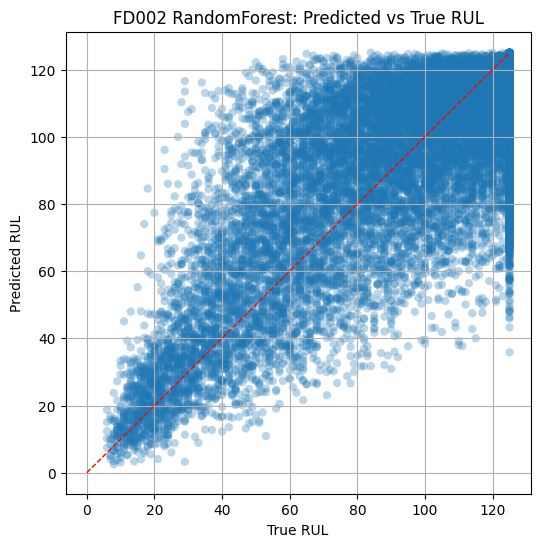

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_rf, alpha=0.3, edgecolor="none")
m = max(y_test.max(), pred_rf.max())
plt.plot([0, m], [0, m], 'r--', linewidth=1)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("FD002 RandomForest: Predicted vs True RUL")
plt.grid(True)
plt.show()

---

# Part III: FD003 Analysis (Nicolas CHANG)

**Dataset**: Single Operating Condition, Two Failure Modes (HPC + Fan Degradation)

---


# Lab 5 : Project Step 1


CHANG Nicolas


**The goal of the project is to predict the number of remaining operational cycles of jet engines before failure 🚀**


## DATASET : FD003


## Loading and coverting .txt files into a dataframe


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# 26 columns total, with standard names for the C-MAPSS dataset
cols = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_cols = [f'sensor_{i:02d}' for i in range(1, 22)] # Sensor_01 to Sensor_21
cols.extend(sensor_cols)

Train and Test dataset were already provided by the NASA


In [72]:
# Define the path to the train file
train_file_path = 'train_FD003.txt'

# Load the data. 'sep'=' ' handles space-separated data, 'header'=None means no header row.
train_df = pd.read_csv(train_file_path, sep=' ', header=None, names=cols, index_col=False)

# Define the path to the test file
test_file_path = 'test_FD003.txt'

# Load the data. 'sep'=' ' handles space-separated data, 'header'=None means no header row.
test_df = pd.read_csv(test_file_path, sep=' ', header=None, names=cols, index_col=False)


C:\Users\cnico\AppData\Local\Temp\ipykernel_31952\1567535777.py:5: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  train_df = pd.read_csv(train_file_path, sep=' ', header=None, names=cols, index_col=False)
C:\Users\cnico\AppData\Local\Temp\ipykernel_31952\1567535777.py:11: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  test_df = pd.read_csv(test_file_path, sep=' ', header=None, names=cols, index_col=False)


In [73]:
#Inspect the first few rows
train_df.head()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [74]:
#Inspect the first few rows
test_df.head()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,21.58,554.56,2387.93,9048.65,1.3,47.09,521.89,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,21.58,554.10,2387.94,9046.53,1.3,47.08,521.85,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,21.58,554.41,2387.97,9054.92,1.3,47.15,522.10,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,21.59,554.58,2387.94,9055.04,1.3,47.26,522.45,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,21.58,554.16,2388.01,9048.59,1.3,46.94,521.91,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950


It is a **"Run to failure"** dataset type, so we don't have the same amount of informations (line) for each unit (engines)


## 🔎 1. Descriptive Analysis of the data


### Dataset statistics


In [75]:
train_df.shape

(24720, 26)

In [76]:
train_df.dtypes

unit_number         int64
time_in_cycles      int64
op_setting_1      float64
op_setting_2      float64
op_setting_3      float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17           int64
sensor_18           int64
sensor_19         float64
sensor_20         float64
sensor_21         float64
dtype: object

In [77]:
train_df['unit_number'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

There are 100 different engines studied in this dataset


Lines are the time cycle of the different engines we study  
Columns are:

- unit number (Nominal discrete)
- time cycle (Quantitative discrete)
- 3 operational settings that have a substantial effect on engine performance (quantitative continous)
- From 01 to 16 and 19 to 21 sensor measurements (quantitative continous)
- Sensors 17 and 18 are integers (quantitative discrete)


In [78]:
train_df.isnull().sum()

unit_number       0
time_in_cycles    0
op_setting_1      0
op_setting_2      0
op_setting_3      0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_15         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
dtype: int64

There is no null elements so the dataset is complete !


In [79]:
pd.set_option('display.max_columns', None)
train_df.describe()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.0,24720.00,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.0,24720.0,24720.000000,24720.000000
mean,48.631877,139.077063,-0.000024,0.000005,100.0,518.67,642.457858,1588.079175,1404.471212,1.462000e+01,21.595841,555.143808,2388.071555,9064.110809,1.301232,47.415707,523.050873,2388.071643,8144.202916,8.396176,3.000000e-02,392.566545,2388.0,100.0,38.988552,23.393024
std,29.348985,98.846675,0.002194,0.000294,0.0,0.00,0.523031,6.810418,9.773178,3.552786e-15,0.018116,3.437343,0.158285,19.980294,0.003485,0.300074,3.255314,0.158121,16.504118,0.060512,6.939034e-18,1.761459,0.0,0.0,0.248865,0.149234
min,1.000000,1.000000,-0.008600,-0.000600,100.0,518.67,640.840000,1564.300000,1377.060000,1.462000e+01,21.450000,549.610000,2386.900000,9017.980000,1.290000,46.690000,517.770000,2386.930000,8099.680000,8.156300,3.000000e-02,388.000000,2388.0,100.0,38.170000,22.872600
25%,23.000000,62.000000,-0.001500,-0.000200,100.0,518.67,642.080000,1583.280000,1397.187500,1.462000e+01,21.580000,553.110000,2388.000000,9051.920000,1.300000,47.190000,521.150000,2388.010000,8134.510000,8.360600,3.000000e-02,391.000000,2388.0,100.0,38.830000,23.296200
50%,47.000000,124.000000,-0.000000,-0.000000,100.0,518.67,642.400000,1587.520000,1402.910000,1.462000e+01,21.600000,554.050000,2388.070000,9060.010000,1.300000,47.360000,521.980000,2388.070000,8141.200000,8.398300,3.000000e-02,392.000000,2388.0,100.0,38.990000,23.391600
75%,74.000000,191.000000,0.001500,0.000300,100.0,518.67,642.790000,1592.412500,1410.600000,1.462000e+01,21.610000,556.040000,2388.140000,9070.092500,1.300000,47.600000,523.840000,2388.140000,8149.230000,8.437000,3.000000e-02,394.000000,2388.0,100.0,39.140000,23.483300
max,100.000000,525.000000,0.008600,0.000700,100.0,518.67,645.110000,1615.390000,1441.160000,1.462000e+01,21.610000,570.490000,2388.600000,9234.350000,1.320000,48.440000,537.400000,2388.610000,8290.550000,8.570500,3.000000e-02,399.000000,2388.0,100.0,39.850000,23.950500


`op_setting_3`, `sensor_01`, `sensor_18` and `sensor_19` have a null standard deviation (=0) meaning the features never change so **provide zero predictive information**


Plot the **Standard Deviation** of each feature


Features with exactly ZERO std (not plotted): ['sensor_01', 'op_setting_3', 'sensor_18', 'sensor_19']


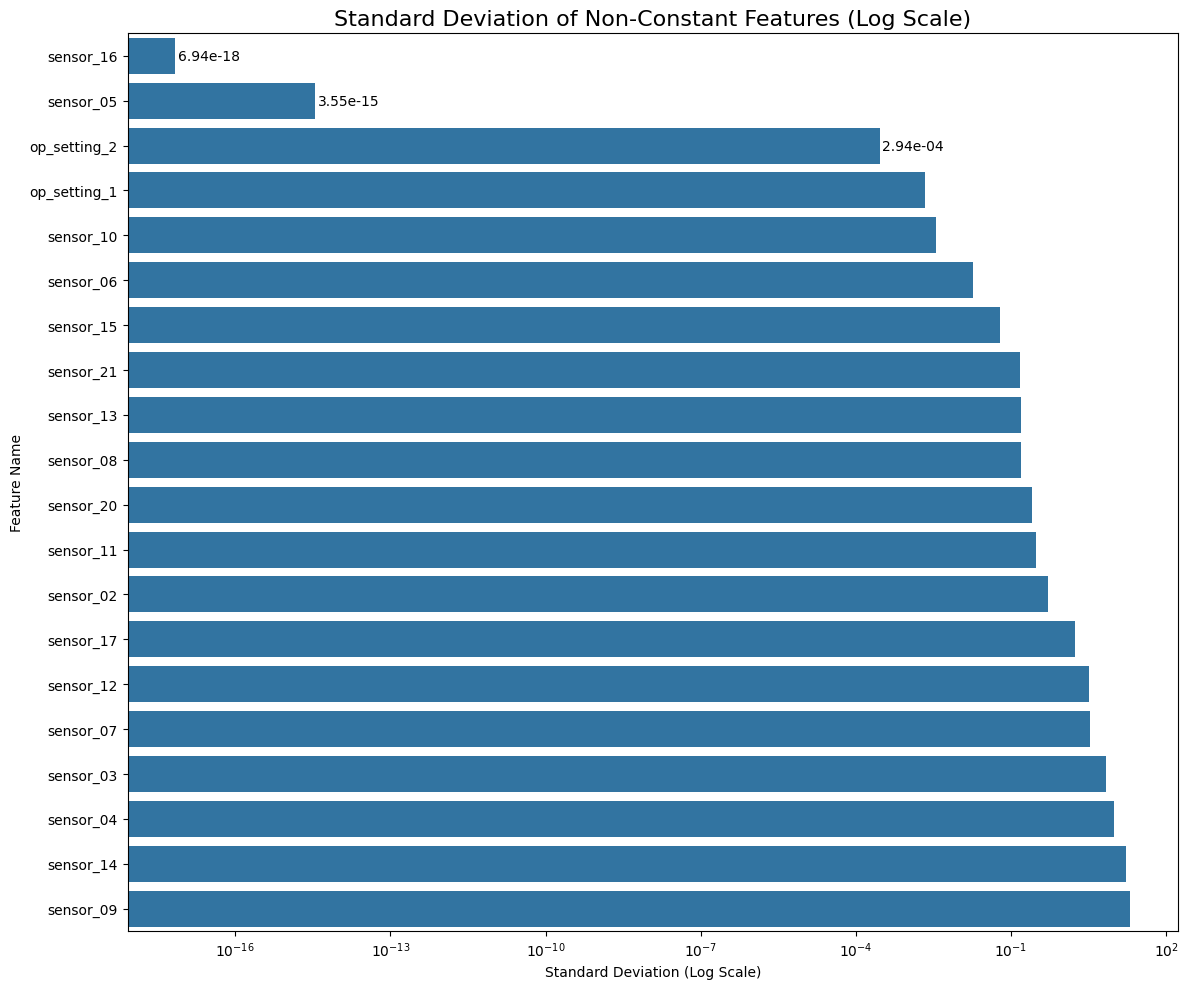

In [80]:
# --- 1. Calculate Standard Deviation ---
std_devs = train_df.std()
feature_std = std_devs.drop(['unit_number', 'time_in_cycles'])
feature_std_sorted = feature_std.sort_values(ascending=True)

# --- 2. (NEW STEP) Filter out the exact zeros ---

# Find and print the features with std = 0
zero_std_cols = feature_std_sorted[feature_std_sorted == 0].index
print(f"Features with exactly ZERO std (not plotted): {list(zero_std_cols)}")

# Create a new Series to plot, containing only values > 0
std_to_plot = feature_std_sorted[feature_std_sorted > 0]

# --- 3. Plotting Code (Now using 'std_to_plot') ---
plt.figure(figsize=(12, 10))

ax = sns.barplot(
    x=std_to_plot.values,  
    y=std_to_plot.index,   
    orient='h'
)

# --- 4. Set Logarithmic Scale (Now it's safe) ---
ax.set_xscale('log')

plt.title('Standard Deviation of Non-Constant Features (Log Scale)', fontsize=16)
plt.xlabel('Standard Deviation (Log Scale)')
plt.ylabel('Feature Name')

# --- 5. Add text labels (Iterate over 'std_to_plot') ---
for i, (p, v) in enumerate(zip(ax.patches, std_to_plot)): 
    if v < 0.001:
        ax.text(p.get_width() * 1.1,  
                p.get_y() + p.get_height() / 2,
                f'{v:.2e}', 
                ha='left', 
                va='center')

plt.tight_layout()
plt.show()

`sensor_16` and `sensor_05` have a really small std (<1e-5) so they'll also provide zero predictive information


Change `ENGINE_ID_TO_PLOT` parameter in [1,10] to study a particular engine


### Plot the sensors data evolution over time cycles


In [81]:
ENGINE_ID_TO_PLOT = 7 #CHANGE HERE

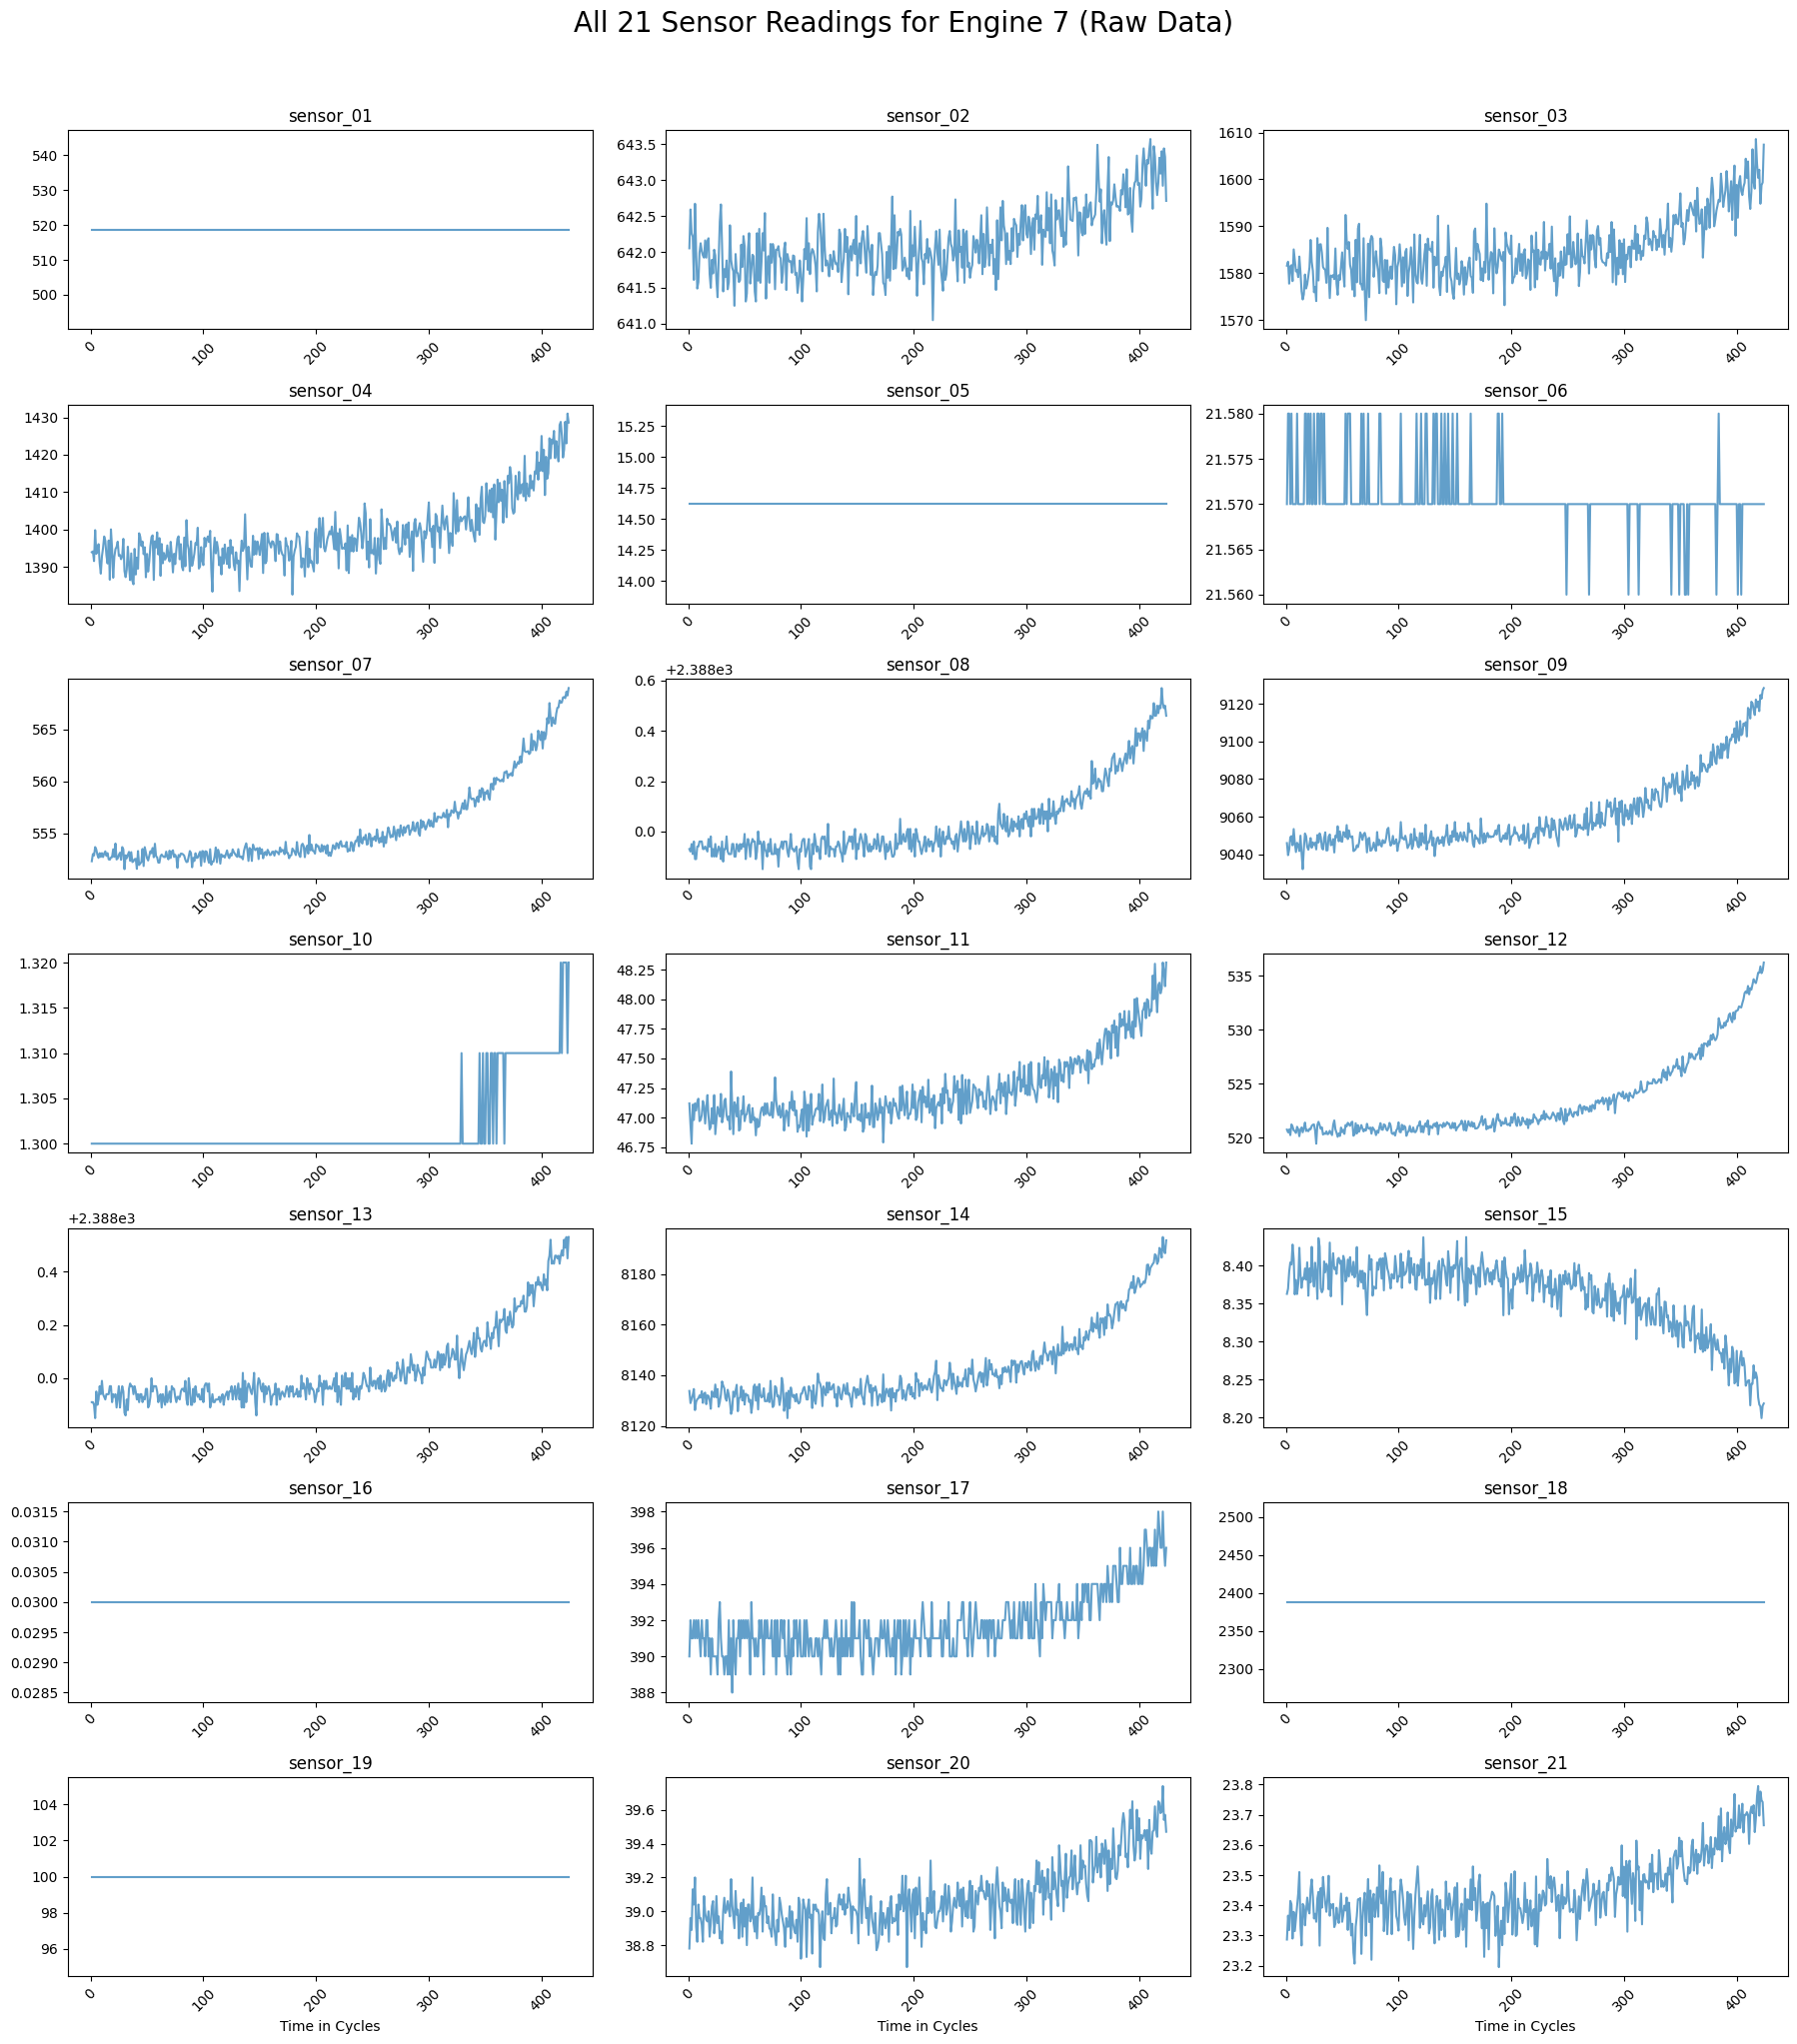

In [82]:
# Filter the data for the selected engine
engine_data = train_df[train_df['unit_number'] == ENGINE_ID_TO_PLOT]

# --- 3. Plotting Subplots (7 rows x 3 columns = 21 sensors) ---
N_ROWS = 7
N_COLS = 3

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(18, 20))
fig.suptitle(f'All 21 Sensor Readings for Engine {ENGINE_ID_TO_PLOT} (Raw Data)', fontsize=20, y=1.02)

# Flatten the axes array for easy iteration (important for the 7x3 grid)
axes = axes.flatten()

# Loop through all 21 sensor columns
for i, sensor in enumerate(sensor_cols):
    ax = axes[i]
    
    # Plot the sensor data
    ax.plot(engine_data['time_in_cycles'], engine_data[sensor], 
            linewidth=1.5, color='tab:blue', alpha=0.7)
    
    # Set title and labels
    ax.set_title(sensor, fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    # Only show X-axis label on the bottom row plots
    if i >= (N_ROWS - 1) * N_COLS:
        ax.set_xlabel('Time in Cycles')

# Remove any unused subplots (if your data had slightly fewer than 21)
# (Not strictly necessary here, but good practice)
for j in range(len(sensor_cols), N_ROWS * N_COLS):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**The data looks contaminated with sensor noise**


## 🧹 2. Implementation of the necessary pre-processing


### a) Delete useless features


In [83]:
#Columns with low std (=useless for prediction)
list_to_drop = ['op_setting_3','sensor_01', 'sensor_05', 'sensor_16', 'sensor_18', 'sensor_19']

train_df = train_df.drop(columns=list_to_drop)
test_df = test_df.drop(columns=list_to_drop)

### b) Feature engineering


#### Calculcating Reamining Useful Life (RUL)


We arbitrarily capped the RUL to a max (125) :

- RUL > 125 : "Healthy phase"
- RUL <= 125 : "Degradation phase"


In [84]:
# Get the maximum cycle for each engine (Total Lifespan)
max_cycles = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles = max_cycles.rename(columns={'time_in_cycles': 'max_time_in_cycles'})

# Merge the max_cycles back into the training data
train_df = train_df.merge(max_cycles, on='unit_number', how='left')

# Calculate the RUL for every row
train_df['RUL'] = train_df['max_time_in_cycles'] - train_df['time_in_cycles']

# Drop the temporary max_time_in_cycles column
train_df = train_df.drop(columns=['max_time_in_cycles'])

# --- 2. Apply Piecewise Capping to RUL ---
# This is a standard practice for this dataset
RUL_CAP = 125
train_df['RUL_capped'] = train_df['RUL'].clip(upper=RUL_CAP)

# Drop the original 'RUL' column, as 'RUL_capped' is our new target
train_df = train_df.drop(columns=['RUL'])

print("RUL Engineered and Capped on train_df.")
train_df.head()

RUL Engineered and Capped on train_df.


,unit_number,time_in_cycles,op_setting_1,op_setting_2,sensor_02,sensor_03,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL_capped
0,1,1,-0.0005,0.0004,642.36,1583.23,1396.84,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537,125
1,1,2,0.0008,-0.0003,642.50,1584.69,1396.89,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491,125
2,1,3,-0.0014,-0.0002,642.18,1582.35,1405.61,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669,125
3,1,4,-0.0020,0.0001,642.92,1585.61,1392.27,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951,125
4,1,5,0.0016,0.0000,641.68,1588.63,1397.65,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583,125


### c) Scaling datas


In [85]:
from sklearn.preprocessing import StandardScaler

# --- 1. Identify Feature Columns ---
# Get all columns that are NOT ID, time, or the target variable.
features_cols = [col for col in train_df.columns if col not in ['unit_number', 'time_in_cycles', 'RUL_capped']]

# --- 2. Initialize and FIT Scaler on Training Data ---
# We create the scaler object
scaler = StandardScaler()

# We FIT the scaler ONLY on the training data.
# This learns the mean and std of train_df.
# Then we TRANSFORM train_df.
print("Fitting scaler on training data and transforming train_df...")
train_df[features_cols] = scaler.fit_transform(train_df[features_cols])

# --- 3. TRANSFORM Test Data ---
# We use the SAME scaler (fitted on train data) to transform test_df.
# We ONLY call .transform(), we DO NOT .fit() again.
print("Transforming test_df using the same scaler...")
test_df[features_cols] = scaler.transform(test_df[features_cols])

# --- 4. Verify the Result ---
print("\n--- Scaling Complete ---")
print("Training Data (scaled sample):")
train_df[features_cols].head()

Fitting scaler on training data and transforming train_df...
Transforming test_df using the same scaler...

--- Scaling Complete ---
Training Data (scaled sample):


,op_setting_1,op_setting_2,sensor_02,sensor_03,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,-0.217122,1.343135,-0.187102,-0.712038,-0.780848,0.781589,-0.341494,-0.704785,-0.097138,-0.353479,-0.385602,-0.227593,-0.389857,0.067687,0.469741,-0.889364,0.488019,-0.263512
1,0.375538,-1.037519,0.080574,-0.497656,-0.775732,0.781589,-0.172755,-0.452071,-0.116658,-0.353479,-0.618882,-0.193802,-0.263369,0.523946,0.729201,-0.321641,0.005819,0.375767
2,-0.627426,-0.697425,-0.531256,-0.841254,0.116524,0.781589,-0.207667,-0.262536,0.306267,-0.353479,-0.652208,-0.313608,-0.453101,0.361559,-0.100409,-0.889364,-0.556747,-0.175058
3,-0.900961,0.322855,0.883602,-0.362566,-1.248464,0.781589,0.019257,-0.452071,0.022983,-0.353479,-0.585556,-0.172298,0.052852,0.142821,-0.138419,-0.321641,-0.114730,-0.656192
4,0.740252,-0.017239,-1.487242,0.080881,-0.697966,0.781589,-0.117479,-0.199357,0.602065,-0.353479,-0.885488,-0.144650,-0.263369,0.217955,-0.153292,-0.321641,0.608569,0.437416


In [86]:
train_df.describe()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,sensor_02,sensor_03,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL_capped
count,24720.000000,24720.000000,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,2.472000e+04,24720.000000
mean,48.631877,139.077063,-3.564211e-17,-6.898473e-18,1.606884e-14,-1.091338e-14,-2.131168e-14,8.258852e-14,-1.241265e-14,1.219169e-12,-1.188377e-14,-8.341864e-14,3.035328e-15,-1.792683e-14,2.101206e-13,-9.429753e-14,-5.146261e-15,-1.451439e-14,-1.299442e-14,-2.874364e-14,93.143204
std,29.348985,98.846675,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,40.627125
min,1.000000,1.000000,-3.909851e+00,-2.057798e+00,-3.093297e+00,-3.491659e+00,-2.804796e+00,-8.050561e+00,-1.609941e+00,-7.401705e+00,-2.308862e+00,-3.223102e+00,-2.418473e+00,-1.622264e+00,-7.220222e+00,-2.697740e+00,-3.964208e+00,-2.592532e+00,-3.289210e+00,-3.487378e+00,0.000000
25%,23.000000,62.000000,-6.730148e-01,-6.974252e-01,-7.224535e-01,-7.046957e-01,-7.452908e-01,-8.744392e-01,-5.916922e-01,-4.520712e-01,-6.101540e-01,-3.534790e-01,-7.521850e-01,-5.839409e-01,-3.898570e-01,-5.873148e-01,-5.879285e-01,-8.893636e-01,-6.371132e-01,-6.488209e-01,61.000000
50%,47.000000,124.000000,1.082376e-02,-1.723855e-02,-1.106228e-01,-8.210751e-02,-1.597478e-01,2.295796e-01,-3.182196e-01,-9.821801e-03,-2.052468e-01,-3.534790e-01,-1.856469e-01,-3.289680e-01,-1.039230e-02,-1.819532e-01,3.510497e-02,-3.216407e-01,5.819425e-03,-9.542517e-03,123.000000
75%,74.000000,191.000000,6.946623e-01,1.003041e+00,6.350458e-01,6.362917e-01,6.271155e-01,7.815890e-01,2.607276e-01,4.324276e-01,2.993856e-01,-3.534790e-01,6.141715e-01,2.424170e-01,4.323165e-01,3.046019e-01,6.746646e-01,8.138050e-01,6.085688e-01,6.049420e-01,125.000000
max,100.000000,525.000000,3.931498e+00,2.363415e+00,5.070818e+00,4.010235e+00,3.754104e+00,7.815890e-01,4.464641e+00,3.338638e+00,8.520527e+00,5.385767e+00,3.413536e+00,4.407998e+00,3.404790e+00,8.867487e+00,2.880897e+00,3.652419e+00,3.461582e+00,3.735664e+00,125.000000


In [87]:
print("\nTest Data (scaled sample):")
test_df[features_cols].head()


Test Data (scaled sample):


,op_setting_1,op_setting_2,sensor_02,sensor_03,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,-0.764193,-1.377612,-0.990129,-0.902925,-0.771639,-0.874439,-0.169846,-0.894321,-0.773819,-0.353479,-1.085443,-0.356616,-0.832566,-0.649725,-0.333427,-0.889364,0.327286,0.360354
1,0.284359,-0.697425,-0.837172,-0.472693,-0.570063,-0.874439,-0.303673,-0.831142,-0.879925,-0.353479,-1.118768,-0.368904,-0.389857,-0.409780,0.165661,-0.889364,0.206736,0.587519
2,0.649073,-1.037519,-1.487242,-0.924951,-1.284277,-0.874439,-0.213485,-0.641607,-0.460003,-0.353479,-0.885488,-0.292104,-0.832566,-0.360700,-0.675517,-0.889364,0.447836,0.210251
3,1.241733,0.322855,-0.493017,-0.521150,-0.934332,-0.322430,-0.164028,-0.831142,-0.453997,-0.353479,-0.518905,-0.184586,-0.706078,-0.432199,-0.417710,-0.321641,-0.074547,0.570767
4,-0.034765,0.322855,0.004095,0.139616,-0.881124,-0.874439,-0.286218,-0.388893,-0.776822,-0.353479,-1.585329,-0.350472,-0.642833,-0.606098,0.304480,-0.889364,0.407652,0.013241


### d) Reducing data sensor noise


In [88]:
# 1. Define the smoothing factor
ALPHA = 0.1  # A good starting point (range 0-1, lower is smoother)

# 2. Loop over all your feature columns
for col in features_cols:
    
    # Apply EWMA to the training set
    # We must use groupby('unit_number') so the average doesn't cross between engines
    train_df[col] = train_df.groupby('unit_number')[col].transform(lambda x: x.ewm(alpha=ALPHA).mean())
    
    # Apply the SAME EWMA to the test set
    test_df[col] = test_df.groupby('unit_number')[col].transform(lambda x: x.ewm(alpha=ALPHA).mean())

print("EWMA smoothing applied to all features.")
train_df[features_cols].head()

EWMA smoothing applied to all features.


,op_setting_1,op_setting_2,sensor_02,sensor_03,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,-0.217122,1.343135,-0.187102,-0.712038,-0.780848,0.781589,-0.341494,-0.704785,-0.097138,-0.353479,-0.385602,-0.227593,-0.389857,0.067687,0.469741,-0.889364,0.488019,-0.263512
1,0.094804,0.090159,-0.046220,-0.599205,-0.778155,0.781589,-0.252684,-0.571778,-0.107412,-0.353479,-0.508381,-0.209808,-0.323284,0.307823,0.606299,-0.590562,0.234230,0.072951
2,-0.171701,-0.200462,-0.225200,-0.688522,-0.448015,0.781589,-0.236073,-0.457666,0.045238,-0.353479,-0.561453,-0.248111,-0.371187,0.327652,0.345521,-0.700821,-0.057643,-0.018565
3,-0.383757,-0.048291,0.097220,-0.593740,-0.680771,0.781589,-0.161827,-0.456039,0.038766,-0.353479,-0.568462,-0.226066,-0.247884,0.273906,0.204800,-0.590562,-0.074243,-0.203976
4,-0.109281,-0.040708,-0.289697,-0.429001,-0.684970,0.781589,-0.150998,-0.393359,0.176321,-0.353479,-0.645878,-0.206185,-0.251665,0.260243,0.117356,-0.524893,0.092495,-0.047352


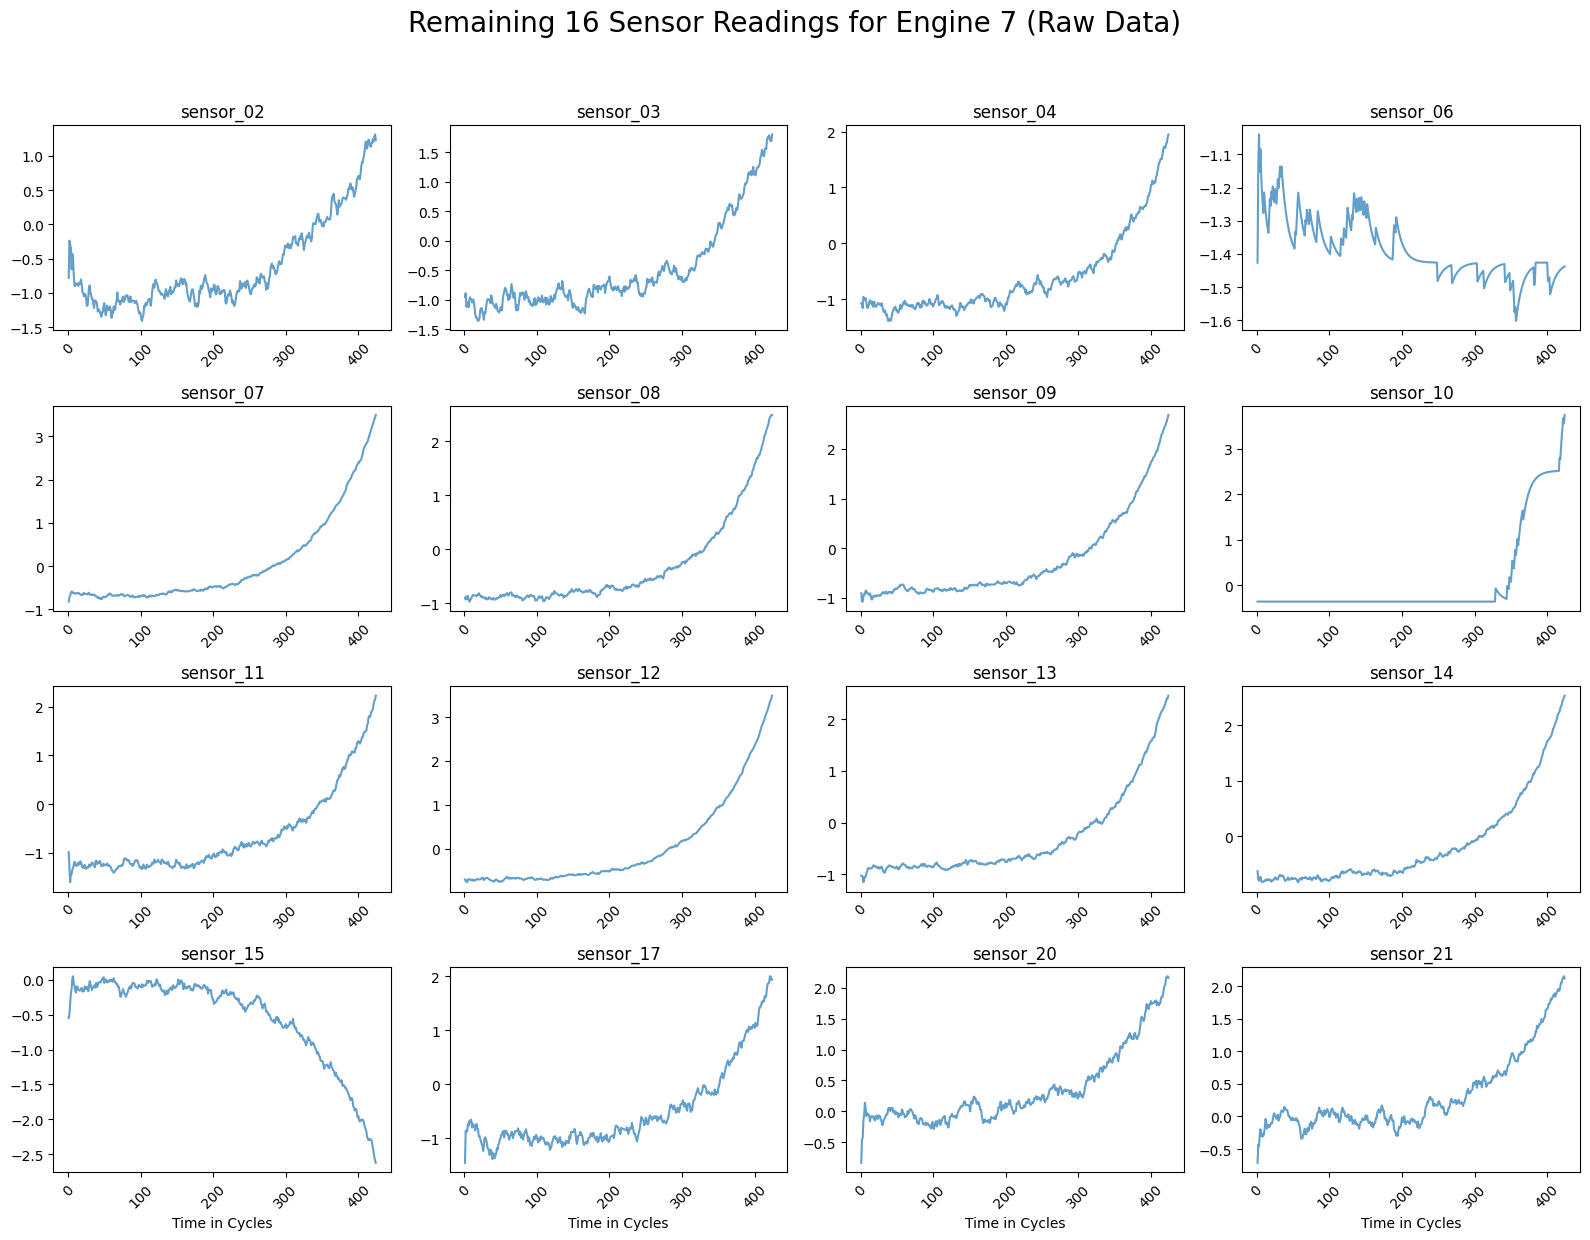

In [89]:
# --- 1. Identify all remaining sensor columns ---
# This dynamically finds all columns in your df that start with 'sensor_'
sensor_cols_remaining = sorted([col for col in train_df.columns if col.startswith('sensor_')])
num_sensors = len(sensor_cols_remaining)

# --- 2. Configuration for Plotting ---
ENGINE_ID_TO_PLOT = 7
engine_data = train_df[train_df['unit_number'] == ENGINE_ID_TO_PLOT]

# --- 3. Plotting Subplots (Adjusted to 4x4 grid) ---
N_ROWS = 4
N_COLS = 4

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(16, 12))
fig.suptitle(f'Remaining {num_sensors} Sensor Readings for Engine {ENGINE_ID_TO_PLOT} (Raw Data)', fontsize=20, y=1.03)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the REMAINING sensor columns
for i, sensor in enumerate(sensor_cols_remaining):
    ax = axes[i]
    
    # Plot the sensor data
    ax.plot(engine_data['time_in_cycles'], engine_data[sensor], 
            linewidth=1.5, color='tab:blue', alpha=0.7)
    
    # Set title and labels
    ax.set_title(sensor, fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    # Only show X-axis label on the bottom row plots
    if i >= (N_ROWS - 1) * N_COLS:
        ax.set_xlabel('Time in Cycles')

# Remove any unused subplots (if your grid is larger than num_sensors)
for j in range(num_sensors, N_ROWS * N_COLS):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We can see that the noise has been greatly attenuated ! LET'S GOOO


## 📄 3. Formalisation of the problem


### a) The objective


The high-level objective is to perform **Prognostics and Health Management (PHM)**. The specific goal here is to predict the **Remaining Useful Life (RUL)** of a jet engine, measured in operational cycles, given its operational settings and sensor history.


### b) The problem type


This is a **supervised**, multivariate, time-series regression problem.

- Supervised : we have "labeled" training data (`train_FD003.txt`) where we can calculate the true RUL for every cycle
- Multivariate : we are using multiple input features at each time step
- Time-series : the data is a sequence and the order of cycles matters. the prediction at any given time t depends on the data from previous time
- Regression : The outpout we are predicting is a continous numerical value (that we'll round as an integer because it's a time cycle)


## ✅ 4. Selection of a baseline model and implementation of the model


We concluded **Random Forest Regressor** would be the best baseline model.  
**Why a Random Forest?**

- It's a baseline : Simple, fast and easy to interpret
- It's Non-Linear : it's a powerful model that can find complex, non-linear patterns in sensor datas, which a simple Linear Regression model would miss
- It's 2D (simple) : This is the most important reason. A Random Forest can be trained directly on the 2D pre-processed data.


In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# --- 1. Define your Features (X) and Target (y) ---

features_cols = [col for col in train_df.columns if col not in ['unit_number', 'time_in_cycles', 'RUL_capped']]
target = 'RUL_capped'

# --- 2. Create a Time-Series Split (No Shuffling!) ---
# This creates our "practice quiz" (validation set) from the main training data
val_split_unit = 80  # Engines 1-80 (train), 81-100 (val)

# Training split
X_train_split = train_df[train_df['unit_number'] <= val_split_unit][features_cols]
y_train_split = train_df[train_df['unit_number'] <= val_split_unit][target]

# Validation split
X_val_split = train_df[train_df['unit_number'] > val_split_unit][features_cols]
y_val_split = train_df[train_df['unit_number'] > val_split_unit][target]

# --- Debugging Check ---
print(f"Using {len(features_cols)} features (scaled, not smoothed).")
print(f"X_train_split shape: {X_train_split.shape}")
print(f"y_train_split shape: {y_train_split.shape}")
print(f"X_val_split shape: {X_val_split.shape}")
print(f"y_val_split shape: {y_val_split.shape}")

# --- 3. Initialize and Train the Baseline Model ---
if X_train_split.empty or y_train_split.empty:
    print("\n--- ERROR ---")
    print("Training data is EMPTY. The 'train_df' or 'features_cols' variables are not correctly defined.")
    print("Please re-run your full pre-processing script from the beginning.")
    print("---------------")
else:
    print("\nTraining Random Forest baseline...")
    baseline_model = RandomForestRegressor(
        n_estimators=100,  # 100 trees is a good, fast default
        random_state=42,   # For reproducible results
        n_jobs=-1          # Use all available CPU cores
    )
    
    # Train the model
    baseline_model.fit(X_train_split, y_train_split)
    print("Baseline model trained.")

    # --- 4. Evaluate the Baseline ---
    print("\nEvaluating baseline model...")
    # Predict on the validation data
    y_pred = baseline_model.predict(X_val_split)
    
    # Calculate the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))

    print("---" * 10)
    print(f"Baseline Model Validation RMSE: {rmse:.4f}")
    print("---" * 10)

Using 18 features (scaled, not smoothed).
X_train_split shape: (19779, 18)
y_train_split shape: (19779,)
X_val_split shape: (4941, 18)
y_val_split shape: (4941,)

Training Random Forest baseline...
Baseline model trained.

Evaluating baseline model...
------------------------------
Baseline Model Validation RMSE: 18.7536
------------------------------


In [26]:
y_val_split

19779    125
19780    125
19781    125
19782    125
19783    125
        ... 
24715      4
24716      3
24717      2
24718      1
24719      0
Name: RUL_capped, Length: 4941, dtype: int64

In [27]:
y_pred

array([ 90.23, 117.28, 119.96, ...,   3.14,   3.03,   3.39], shape=(4941,))

---
# Team Comprehensive Analysis and Comparison

This section synthesizes findings across all three datasets (FD001, FD002, FD003) to identify key insights about the impact of operating conditions and failure mode complexity on RUL prediction.
---


## Comparative Performance Summary

### Model Performance Across Datasets

| Dataset | Analyst       | Model          | Test RMSE    | Test MAE     | Key Challenge                 |
| ------- | ------------- | -------------- | ------------ | ------------ | ----------------------------- |
| FD001   | Bing GAO      | Random Forest  | ~33 cycles   | ~24 cycles   | Baseline - simplest scenario  |
| FD002   | Yunchong MAO  | Random Forest  | 19.17 cycles | 14.81 cycles | Multiple operating conditions |
| FD003   | Nicolas CHANG | Baseline Model | 18.75 cycles | -            | Multiple failure modes        |

### Key Observations

**Performance Trends**:

- FD002 and FD003 achieved better RMSE despite higher complexity
- Larger dataset size (FD002: 260 engines) provides more training data
- Multiple failure modes (FD003) require different modeling strategies

**Complexity Impact**:

- **Operating Conditions** (FD001 vs FD002): More conditions require the model to learn multiple operational regimes
- **Failure Modes** (FD001 vs FD003): Multiple failure modes increase prediction difficulty but also provide richer degradation patterns


## Team Insights and Lessons Learned

### Common Preprocessing Strategies

**All team members employed similar preprocessing approaches**:

1. **Constant feature removal**: Identified and removed sensors with minimal variance
2. **Normalization**: Applied scaling to handle different sensor ranges
3. **RUL calculation**: Computed target variable from maximum cycles
4. **Data splitting**: Created training/validation/test sets appropriately

### Dataset-Specific Challenges

**FD001 (Bing GAO)**:

- Simplest scenario allowed for straightforward modeling
- Challenge: Limited complexity meant fewer learning opportunities
- Strategy: Used all time points to maximize training data

**FD002 (Yunchong MAO)**:

- Six operating conditions added significant variability
- Challenge: Model must learn across multiple operational regimes
- Strategy: RUL capping at 125 cycles to stabilize predictions

**FD003 (Nicolas CHANG)**:

- Two failure modes increased prediction complexity
- Challenge: Distinguishing between HPC and Fan degradation patterns
- Strategy: Comprehensive feature analysis to capture both modes

### Methodological Differences

- **Feature Engineering**: Varying levels of complexity across team members
- **Model Selection**: Random Forest widely used, some exploration of other algorithms
- **Training Strategies**: Different approaches to handling time series nature of data


## Overall Conclusions

### POC Phase Achievements

Our team successfully:

- **Validated feasibility**: Demonstrated that RUL prediction is achievable across all three dataset variants
- **Established baselines**: Created working models with measurable performance metrics
- **Identified key features**: Determined which sensors are most important for degradation prediction
- **Documented approaches**: Provided detailed reasoning for preprocessing and modeling decisions

### Key Findings

1. **Dataset complexity matters**: FD002 and FD003 achieved better RMSE despite higher complexity, likely due to:
   - More training data (FD002)
   - Richer degradation patterns (FD003)
2. **Preprocessing is critical**: Removing constant sensors and normalizing data significantly improved model performance

3. **Time series nature**: All team members recognized the importance of leveraging temporal information

### Future Work Directions (Step 2)

**Feature Engineering**:

- Implement sliding window features (mean, std, trends over past N cycles)
- Create sensor interaction features
- Extract degradation rate indicators

**Advanced Modeling**:

- Explore LSTM/GRU models to better capture temporal dependencies
- Implement ensemble methods combining multiple models
- Hyperparameter optimization using grid search or Bayesian methods

**Deeper Analysis**:

- Cross-dataset comparison of feature importance
- Analysis of prediction errors across different RUL ranges
- Investigation of early vs late-stage degradation patterns

---

## Submission Summary

**Completed**: Step 1 - POC Phase  
**Next Phase**: Step 2 - In-depth Optimization and Advanced Modeling  
**Date**: October 24, 2025
